## Nutrient Limitation

Compute biomass-weighted-mean limitation terms in the upper ocean (i.e., top 150 m).

Make 3 panel plot: maps of most limiting nutrient for each phytoplankton taxa (diatom, small phyto, diazotrophs).

In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs

import intake
import intake_esm
import ann_avg_utils as aau

import ncar_jobqueue
from dask.distributed import Client

import xpersist as xp
# Set up xperist cache
cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache')
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
xp_dir = 'nutrient_limitation'
os.makedirs(os.path.join(xp.settings['cache_dir'], xp_dir), exist_ok=True)

import utils

# MCL: commenting this out, getting type error
#%load_ext watermark
#%watermark -a "Mike Levy" -d -iv -m -g -h

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ncar_jobqueue/cluster.py:31: UserWarning: Unable to determine which NCAR cluster you are running on... Using an instance of `distributed.LocalCluster` class.
  'Unable to determine which NCAR cluster you are running on... Using an instance of `distributed.LocalCluster` class.'


In [2]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.57:43584 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/37056/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
global_vars = aau.global_vars()

exp = 'cesm2_hist'
time_slices = global_vars['time_slices']
experiment_dict = global_vars['experiment_dict']

In [4]:
%%time

temp_thres_diaz = 15.

def _get_all_limitation_vars(autotroph):
    catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json', 
                                        sep=':')

    darrays = []
    nutrient_dim = []
    for nutrient in nutrients:
        if (autotroph, nutrient) not in omit:
            if nutrient == 'TEMP':
                var = 'TEMP'
                da = catalog.search(
                        experiment=experiment_dict[exp][1], 
                        variable=var
                    ).to_dataset_dict(
                        cdf_kwargs={'chunks':{'time' : 180}}
                    )['ocn:historical:pop.h'].drop(['ULAT', 'ULONG']).sel(
                        time=time_slices[exp],
                    ).isel(
                        z_t=0,
                        drop=True,
                    )[var].mean(['time', 'member_id'])

                da = xr.where(da > temp_thres_diaz, 1., 0.)
                darrays.append(da)                
            else:
                var = f'{autotroph}_{nutrient}_lim_Cweight_avg_100m'
                print(f'Reading data for {var}')
                # Looking at historical run
                darrays.append(
                    catalog.search(
                        experiment=experiment_dict[exp][1], 
                        variable=var
                    ).to_dataset_dict(
                        cdf_kwargs={'chunks':{'time' : 180}}
                    )['ocn:historical:pop.h'].drop(['ULAT', 'ULONG']).sel(
                        time=time_slices[exp]
                    )[var].mean(['time', 'member_id'])
                )
            variables.append(var)
            nutrient_dim.append(nutrient)
        else:
            print(f'Will not pair {autotroph} and {nutrient}')
    datasets = xr.concat([da.to_dataset(name=f'{autotroph}_lim') for da in darrays], dim='nutrient')
    datasets['nutrient'] = nutrient_dim
    
    return(datasets.compute())

variables = []
nutrients = ['P', 'Fe', 'N', 'SiO3', 'TEMP']
omit = [('sp', 'SiO3'), ('diaz', 'SiO3'), ('diaz', 'N'), ('sp', 'TEMP'), ('diat', 'TEMP')]
darrays = dict()
datasets = dict()
dsets_plot = dict()
for autotroph in ['sp', 'diat', 'diaz']:
    xp_func = xp.persist_ds(_get_all_limitation_vars, name=f'{xp_dir}/{autotroph}_lim', trust_cache=True)
    datasets[autotroph] = xp_func(autotroph)
    dsets_plot[autotroph] = utils.pop_add_cyclic(datasets[autotroph])
datasets

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/sp_lim.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/diat_lim.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/nutrient_limitation/diaz_lim.nc
CPU times: user 53.7 ms, sys: 24.2 ms, total: 77.9 ms
Wall time: 163 ms


{'sp': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 320, nutrient: 3)
 Coordinates:
     TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
     TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
   * nutrient  (nutrient) object 'P' 'Fe' 'N'
 Dimensions without coordinates: nlat, nlon
 Data variables:
     sp_lim    (nutrient, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan,
 'diat': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 320, nutrient: 4)
 Coordinates:
     TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
     TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
   * nutrient  (nutrient) object 'P' 'Fe' 'N' 'SiO3'
 Dimensions without coordinates: nlat, nlon
 Data variables:
     diat_lim  (nutrient, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan,
 'diaz': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 320, nutrient: 3)
 Coordinates:
     TLONG     (nlat, 

In [5]:
dsets_aligned = xr.align(*[ds for ds in dsets_plot.values()], join='outer', fill_value=100.)
dsets_plot = {k: ds for k, ds in zip(['sp', 'diat', 'diaz'], dsets_aligned)}
dsets_plot

{'sp': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 321, nutrient: 5)
 Coordinates:
   * nutrient  (nutrient) object 'Fe' 'N' 'P' 'SiO3' 'TEMP'
 Dimensions without coordinates: nlat, nlon
 Data variables:
     TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
     TLONG     (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.29 -39.57 -39.86
     sp_lim    (nutrient, nlat, nlon) float32 nan nan nan ... 100.0 100.0 100.0,
 'diat': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 321, nutrient: 5)
 Coordinates:
   * nutrient  (nutrient) object 'Fe' 'N' 'P' 'SiO3' 'TEMP'
 Dimensions without coordinates: nlat, nlon
 Data variables:
     TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
     TLONG     (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.29 -39.57 -39.86
     diat_lim  (nutrient, nlat, nlon) float32 nan nan nan ... 100.0 100.0 100.0,
 'diaz': <xarray.Dataset>
 Dimensions:   (nlat: 384, nlon: 321, nutrient: 5)
 Coordinates:
   

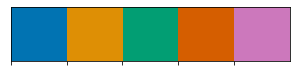

In [6]:
current_palette = sns.color_palette('colorblind', 5)
cmap = ListedColormap(current_palette.as_hex())
sns.palplot(current_palette)

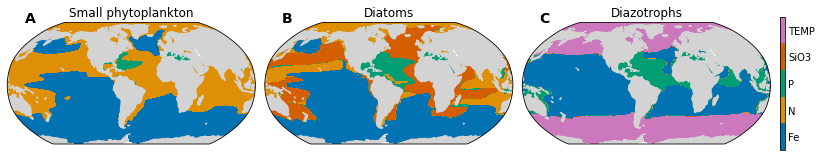

In [7]:
fig = plt.figure(figsize=(12,3.5))
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=(1, 1, 1, 0.02))

prj = ccrs.Robinson(central_longitude=305.0)

ocn_mask = np.where(np.isnan(dsets_plot['sp']['sp_lim'].isel(nutrient=0).data), False, True)
levels = np.arange(6)
norm = colors.BoundaryNorm(levels, ncolors=5)


current_palette = sns.color_palette('colorblind', 5)
cmap = ListedColormap(current_palette.as_hex())

autotroph_names = dict(
    sp='Small phytoplankton',
    diat='Diatoms',
    diaz='Diazotrophs',
)

maps = []
for n, autotroph in enumerate(['sp', 'diat', 'diaz']):
    ds = dsets_plot[autotroph]
    da = ds[f'{autotroph}_lim']
    ax = fig.add_subplot(gs[0, n], projection=prj)
    maps.append(ax)
    ax.set_title(autotroph_names[autotroph], fontsize=12)
    
    pc = ax.contourf(ds['TLONG'].data,
                     ds['TLAT'].data,
                     da.argmin(dim='nutrient', skipna=False).where(ocn_mask).data+0.5,
                     levels=levels,
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())
    
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='lightgray'
        )
    )        

# add colorbar
gs.update(left=0.05, right=0.95, hspace=0.05, wspace=0.05)
cax_vert_shrink = 0.7
cbar_ax = plt.subplot(gs[0, -1])
p0 = cbar_ax.get_position()
shift_up = p0.height * (1. - cax_vert_shrink) / 2
cbar_ax.set_position([p0.x0, p0.y0 + shift_up, p0.width, p0.height * cax_vert_shrink])

cbar = fig.colorbar(pc, cax=cbar_ax, ticks=levels+.5, orientation='vertical')

cbar.ax.set_yticklabels([f'{nutrient}' for nutrient in dsets_plot['sp'].nutrient.values]);
cbar.ax.tick_params(length=0);

utils.label_plots(fig, maps, xoff=0.02, yoff=0)   
utils.savefig('nutrient-limitation-maps')